<a href="https://colab.research.google.com/github/TejasMapsekar/Text-Sentiment-analysis-/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
from google.colab import files

!mkdir -p ~/.kaggle
files.upload()

!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [3]:
!pip install -U -q kaggle

In [4]:
# !kaggle datasets download -d kazanova/sentiment140
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 19% 5.00M/25.7M [00:00<00:00, 41.6MB/s]
100% 25.7M/25.7M [00:00<00:00, 147MB/s] 


In [5]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [6]:
import pandas as pd

df = pd.read_csv("/content/IMDB Dataset.csv",encoding="utf-8")


In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
print(df["sentiment"].unique(),df["sentiment"].isnull().sum())

['positive' 'negative'] 0


In [9]:
y = df["sentiment"].tolist()
y_int = []

for item in y:
  if(item=="positive"):
    y_int.append(1)
  else:
    y_int.append(0)

y = y_int

In [10]:
y = np.array(y)

In [11]:
print(y.shape)
print("catagories=",np.unique(y))

(50000,)
catagories= [0 1]


In [12]:
x = df["review"].tolist()
print(len(x),type(x[0]))

50000 <class 'str'>


In [13]:
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup as bs
import re
import string
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('wordnet')

sw_nltk = stopwords.words('english')

refined = []
for item in x:

  words = [word.lower() for word in item.split() if word.lower() not in sw_nltk]
  removed_stop = " ".join(words)
  removed_html = bs(removed_stop).get_text()
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  removed_url = url_pattern.sub(r'',removed_html)
  removed_punctuation = removed_url.translate(str.maketrans('','',string.punctuation))
  
  lemmatized_words = [lemmatizer.lemmatize(w, wordnet.VERB) for w in removed_punctuation.split()] 
  lemmatized_sent = " ".join(lemmatized_words)

  refined.append(lemmatized_sent)

x = refined

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
x[10]

'phil alien one quirky film humour base around oddness everything rather actual punchlinesat first odd pretty funny movie progress find joke oddness funny anymoreits low budget film thats never problem itself pretty interest character eventually lose interesti imagine film would appeal stoner currently partakingfor something similar better try brother another planet'

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70,test_size=0.30, random_state=101)

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=5000, oov_token="<oov>")
tokenizer.fit_on_texts(x_train)


In [19]:
word_index = tokenizer.word_index
for index, (key, value) in enumerate(word_index.items()):
    print(key, value)
    if(index >50):
      break

<oov> 1
film 2
movie 3
one 4
make 5
like 6
see 7
get 8
time 9
good 10
character 11
watch 12
go 13
even 14
would 15
think 16
really 17
story 18
show 19
it 20
look 21
much 22
say 23
well 24
know 25
end 26
people 27
great 28
bad 29
also 30
give 31
take 32
play 33
first 34
love 35
act 36
come 37
find 38
movies 39
could 40
way 41
seem 42
work 43
many 44
want 45
plot 46
two 47
never 48
be 49
try 50
little 51
best 52


In [20]:
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences,padding="post",maxlen=100,truncating="post")

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences,padding="post",maxlen=100,truncating="post")

In [21]:
print(train_padded.shape,y_train.shape,test_padded.shape,y_test.shape)

(35000, 100) (35000,) (15000, 100) (15000,)


In [22]:
import tensorflow as tf

def builder(hp):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(5000,hp.Int("embedding_layer", min_value=16, max_value=64, step=6), input_length=100),
      tf.keras.layers.LSTM(20),
      tf.keras.layers.Dense(hp.Int("first_dense_layer", min_value=64, max_value=128, step=32), activation='relu'),
      tf.keras.layers.Dense(hp.Int("seond_dense_layer", min_value=128, max_value=256, step=64), activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model


In [23]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 29.1 MB/s 
     |████████████████████████████████| 1.6 MB 34.1 MB/s 


In [24]:
from keras_tuner import RandomSearch
tuner = RandomSearch(
    builder,
    objective="accuracy",
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="models",
    project_name="cnn",
)

In [25]:
tuner.search(train_padded[0:2000], y_train[0:2000], epochs=1, validation_data=(test_padded[0:200], y_test[0:200]))

Trial 54 Complete [00h 00m 04s]
accuracy: 0.5195000171661377

Best accuracy So Far: 0.5224999785423279
Total elapsed time: 00h 03m 31s


In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
print(best_hps.values)

{'embedding_layer': 58, 'first_dense_layer': 64, 'seond_dense_layer': 128}


In [27]:
history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test), verbose=1)

Epoch 1/10
1094/1094 [==============================] - 12s 9ms/step - loss: 0.4260 - accuracy: 0.7947 - val_loss: 0.3467 - val_accuracy: 0.8532
Epoch 2/10
1094/1094 [==============================] - 9s 9ms/step - loss: 0.2993 - accuracy: 0.8779 - val_loss: 0.3897 - val_accuracy: 0.8437
Epoch 3/10
1094/1094 [==============================] - 10s 9ms/step - loss: 0.2602 - accuracy: 0.8937 - val_loss: 0.3658 - val_accuracy: 0.8546
Epoch 4/10
1094/1094 [==============================] - 9s 9ms/step - loss: 0.2209 - accuracy: 0.9125 - val_loss: 0.3946 - val_accuracy: 0.8511
Epoch 5/10
1094/1094 [==============================] - 11s 10ms/step - loss: 0.1803 - accuracy: 0.9332 - val_loss: 0.4100 - val_accuracy: 0.8247
Epoch 6/10
1094/1094 [==============================] - 9s 9ms/step - loss: 0.1516 - accuracy: 0.9449 - val_loss: 0.4394 - val_accuracy: 0.8335
Epoch 7/10
1094/1094 [==============================] - 10s 9ms/step - loss: 0.1279 - accuracy: 0.9551 - val_loss: 0.4850 - val_accu

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 58)           290000    
                                                                 
 lstm_1 (LSTM)               (None, 20)                6320      
                                                                 
 dense_3 (Dense)             (None, 64)                1344      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 306,113
Trainable params: 306,113
Non-trainable params: 0
_________________________________________________________________


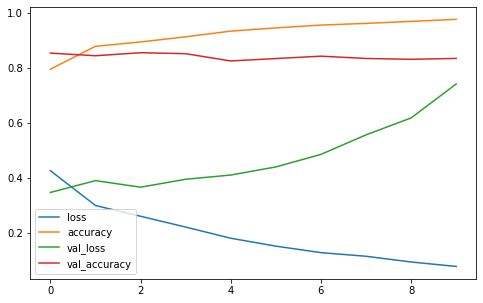

In [29]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [30]:
loss,accuracy = model.evaluate(test_padded,y_test)
print("acuracy =",accuracy)

469/469 [==============================] - 2s 4ms/step - loss: 0.7410 - accuracy: 0.8339
acuracy = 0.8339333534240723


In [31]:
model.save("sentiment.h5")

In [32]:
import random
r = random.randint(0,len(test_padded)-1)
pred = model.predict(np.expand_dims(test_padded[r],axis=0))
print("predicted negative" if int(np.round(pred[0]))==0 else "predicted positive")
print("actual negative" if y_test[r]==0 else "actual positive")
print(x_test[r])

predicted positive
actual positive
watch unaired episodes online sad show back best cast mature talented actors amaze chemistry seem like actors personal friends real life towards end show become engage sexy highly watchable course story line realistic what character likable root them show remind cross 2 favorites sex city felicity big kudos cast note abc execs nielsen rat report show true result show audience mostly record it ive disappoint major network flood us realitytv teenage orient show get mature thoughtful wellacted material switch hbo fx thank network put rest episodes online new stream media gain popularity among viewers


In [33]:

import pickle

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [34]:
from keras.models import load_model

model = load_model("sentiment.h5")

In [35]:
import pickle

tokenizer = None
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [50]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup as bs
import re
import string

x = [input()]

lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('wordnet')

sw_nltk = stopwords.words('english')

refined = []
for item in x:

  words = [word.lower() for word in item.split() if word.lower() not in sw_nltk]
  removed_stop = " ".join(words)
  removed_html = bs(removed_stop).get_text()
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  removed_url = url_pattern.sub(r'',removed_html)
  removed_punctuation = removed_url.translate(str.maketrans('','',string.punctuation))
  
  lemmatized_words = [lemmatizer.lemmatize(w, wordnet.VERB) for w in removed_punctuation.split()] 
  lemmatized_sent = " ".join(lemmatized_words)

  refined.append(lemmatized_sent)

xt = refined

waste of time


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
xt_sequences = tokenizer.texts_to_sequences(xt)
xt_padded = pad_sequences(xt_sequences,padding="post",maxlen=100,truncating="post")

In [38]:
xt_padded.shape

(1, 100)

In [39]:
pred = model.predict(xt_padded)

In [48]:
import numpy as np

print("predicted negative" if int(np.round(pred[0]))==0 else "predicted positive")

predicted negative


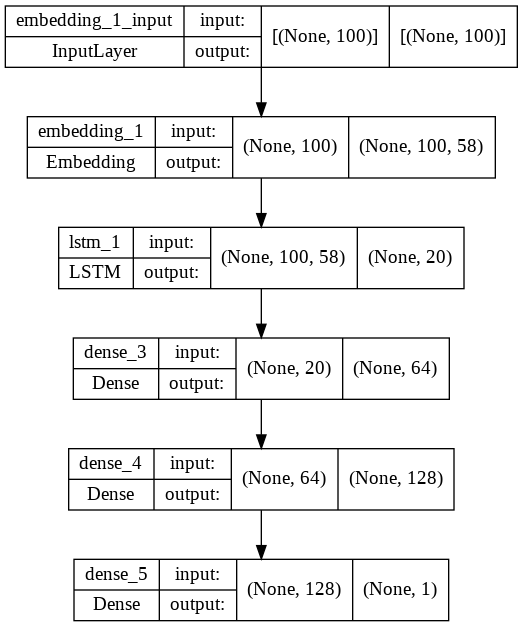

In [49]:
from tensorflow.keras.utils import plot_model as plotter
plotter(model, to_file="arch.png", show_shapes=True, show_layer_names=True)

In [42]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-w5oyi_ue
  Running command git clone -q https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-w5oyi_ue
     |████████████████████████████████| 989 kB 32.5 MB/s 
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13449 sha256=24c3e72c409ee406b6e20ad3a631d1ff550d550181a40f06a1eaf8cf85c78b63
  Stored in directory: /tmp/pip-ephem-wheel-cache-95sjy90q/wheels/b8/3b/cf/30a062e766188d5fe50abf3d461720943b7d09906e3d261a94
Successfully built visualkeras


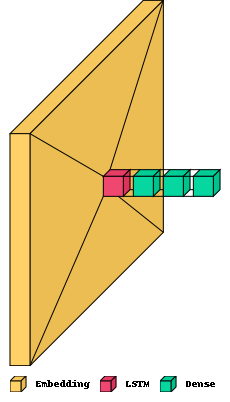

In [43]:
import visualkeras

visualkeras.layered_view(model,legend=True)